# Functional connectivity profiles

Requires computations from scripts
- p1_connectivity_profiles_binary_matrices.py -> to compute binary matrices
- p1_connectivity_profiles_sex_diff.py -> to test the significance of sex differences in connectivity profiles (top 10% fc connections) via Chi-square test of independence and odds ratio

## Load packages

In [219]:
# General
import numpy as np
import pandas as pd
import os
import csv

# Computing
import scipy.io
from scipy import stats
from heapq import nlargest  # gives you the largest values of a list
from statsmodels.stats.multitest import fdrcorrection

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [4]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'
datadir_geodesic = '/data/p_02721/geodesic_HCP/mica_pipe/output/micapipe/'

resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'
resdir_fig = '/data/p_02667/sex_diff_gradients/results/figures/'

In [5]:
path_list = os.listdir(datadir_geodesic)
path_list.sort()

# Data

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)



- **So a parcel cannot belong to more than 1 network..? LIMITATION NO? -> Yes. Shanmugan et al. (2022) for example use loading onto a network (i.e., not discrete)** 

In [6]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


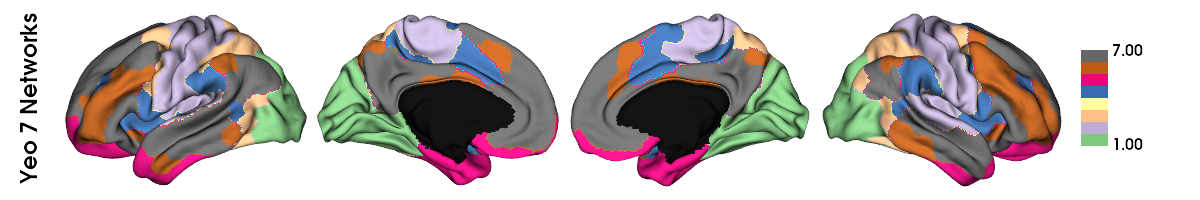

In [7]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [8]:
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [9]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [10]:
network_names = ["visual", "sensory motor", "DMN", "dorsal attention", "ventral attention", "limbic", "fronto parietal"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- DMN: 90
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 53


## Load fc data (needed to compute mean geodesic distance for top 10% of fc connections)

## Get subsample of fc matrices that has full data (matching HCP_sub_list_final)

## Load demographics data to retrieve sex of subjects

# Compute functional connectivity profiles

## Binary matrices

This has been computed by p1_connectivity_profiles_binary_matrices.py

Explanation:
- for each subject, compute 400x400 matrices with binary coding showing whether an fc connection is in the top 10% (out of 200 -> top 20) connections for a given area (in a row) 
- coding: in top 10% of connections (1), NOT in the top 10% of connections (0)

### Loading from mat files (just to visualize)

In [22]:
# binary matrices
scipy.io.whosmat(resdir_hcp+'binary_top_fc.mat')

[('binary_top_fc', (1000, 400, 400), 'int64'),
 ('binary_top_fc_M', (464, 400, 400), 'int64'),
 ('binary_top_fc_F', (536, 400, 400), 'int64')]

In [23]:
# loading the full sample binary matrices
binary_top_fc = scipy.io.loadmat(resdir_hcp+'binary_top_fc.mat')['binary_top_fc']

# loading the binary matrices by sex
binary_top_fc_M = scipy.io.loadmat(resdir_hcp+'binary_top_fc.mat')['binary_top_fc_M']
binary_top_fc_F = scipy.io.loadmat(resdir_hcp+'binary_top_fc.mat')['binary_top_fc_F']

just a check to see that indeed took 10% of top connections (out of 200 parcels)

In [27]:
np.count_nonzero(binary_top_fc[0][0] == 1)

20

#### Full matrix

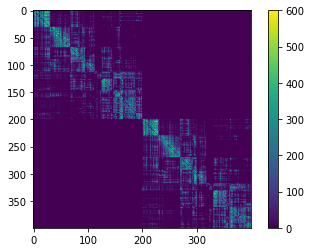

(464, 400, 400)

In [169]:
plt.imshow(sum(binary_top_fc_M))
plt.colorbar()
plt.clim(0, 600)
plt.show()

binary_top_fc_M.shape

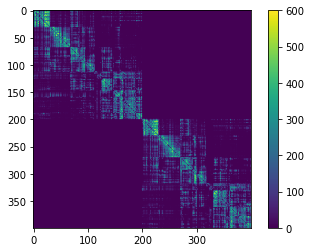

(536, 400, 400)

In [170]:
plt.imshow(sum(binary_top_fc_F))
plt.colorbar()
plt.clim(0, 600)
plt.show()

binary_top_fc_F.shape

#### Matrix left hemisphere

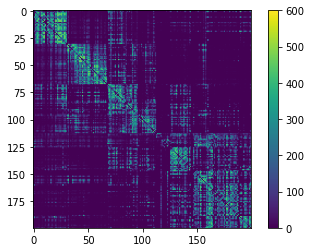

In [96]:
plt.imshow(sum(binary_top_fc_M)[:200, :200])
plt.colorbar()
plt.clim(0, 600)
plt.show()

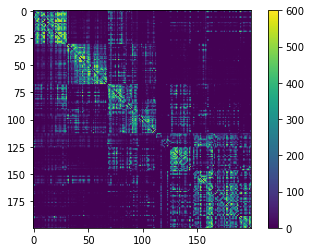

In [99]:
plt.imshow(sum(binary_top_fc_F)[:200, :200])
plt.colorbar()
plt.clim(0, 600)
plt.show()

# Test sex differences in connectivity profiles 

Via:
- Chi-square test of indepndence (H0) of variables in contingency table to test the indepdence of variables "sex" (rows) and "area is/is not in top 10% of functional connections" (columns) -> non-independence == sex differences in top 10% of connections
- Odds Ratio (effect size)

###  Compute sex differences (measures: Chi-square test of indipendence of variables FDR-corrected q values and odds ratio)

This has been computed by p1_connectivity_profiles_sex_diff.py

Explanation:
- for every row (parcel) in binary matrix, for ever parcel in row of binary matrix -> make a contingency table 
- for contingency table, need to a) count the number of males and females (separately) that have this area marked (with a 1) as being one of the top 10% of connections (simply take the sum across subjects for this cell in matrix given that if area is not in top 10% of connections, it is marked with 0) and b) deduce the counts of subjects for which this areas is not part of top 10% connections
- With contingency table, can compute a) Chi-square test of independence of variables, b) (from contents of table) the Odds Ratio

In [ ]:
# list that will contain the matrix of p values for the Chi-square test of independence of variables in contingency table to see sex differences in top 10% of connections
chisquare_pval_matrix = []

# list that will contain the matrix of Odds Ratio from contingency table (to-be-used as effect size for Chi-square test of indepndence of variables)
OR_matrix = []

        
# transposing the binary_top_fc array in order to have it in shape 400 x 400 x N -> iterating over 400 parcels
for i in range(len(binary_top_fc.T)):
    
    print(f"-------- matrix row: {i} --------")
    
    # temporary lists that will contail the rows of the chisquare_pval_matrix and OR_matrix
    temp_row_chisquare_pval_matrix = []
    temp_row_OR_matrix = []
    
    
    # iterating over 400 parcels
    for j in range(len(binary_top_fc.T[0])):
        
        print(f"matrix column: {j}")
        
        # only run Chi-square test if i and j are not the same (otherwise we're at the intersection of the parcel's connection with itself in the matrix, and the value for it is 0 (i.e., not chosen as a top connection))
        if i != j:
        
            ### creating contingency table with counts of occurances for Chi-square test of indepndence of variables to test if there are statistically significant sex differences in top 10% of fc connections
            # C: connection (area) in top 10%; NC: connection (area) not in top 10%; m: male; f: female
            # row: male (top), female (bottom)
            # columns: C (left), NC right

            contingency_table = []
            Cm = 0
            NCm = 0
            Cf = 0
            NCf = 0
            
            
            ## male row
            Cm = sum(binary_top_fc_M.T[i][j])
            NCm = len(binary_top_fc_M) - Cm  # number of male subjects minus sum of counts in the top 10%

            # append male row to table
            contingency_table.append([Cm, NCm])


            ## female row
            Cf = sum(binary_top_fc_F.T[i][j])
            NCf = len(binary_top_fc_F) - Cf  # number of male subjects minus sum of counts in the top 10%

            # append female row to table
            contingency_table.append([Cf, NCf])

            contingency_table = np.array(contingency_table)
            
            
            # compute Odds Ratio (regardless of pvalue of Chi-square test)
            OR = (Cm/NCm)/(Cf/NCf)
            
            # in case the OR == infinity (because dividing by zero), recompute the OR: can replace the 0 at denominator by 0.5 for more interpretability (https://www.researchgate.net/post/How_to_calculate_OR_odd_ratio_if_one_of_groups_is_0_in_a_case-control_study)
            if OR == float('inf'):
                if NCm == 0:
                    NCm = 0.5
                if NCf == 0:
                    NCf = 0.5
                               
                # recompute OR 
                OR = (Cm/NCm)/(Cf/NCf)
                
                # if still == inf, it means that the whole denominator is == 0, replace it by 0.5
                if OR == float('inf'):
                    
                    # recompute OR
                    OR = (Cm/NCm)/0.5
                    

            # append OR to row
            temp_row_OR_matrix.append(OR)
            
            
            # only run Chi-square test if there aren't just zeros in both columns (ie either male or female has area as one of top connections (totC > 0) or not all males and all females have area chosen as top connection (totNC > 0) - otherwise throws an error
            if (Cm + Cf > 0) and (NCm + NCf > 0):
                ### Chi-square test of independence of variables in a contingency table, [1] indexes the p val
                p_val = stats.chi2_contingency(contingency_table)[1]

                # append p value to row
                temp_row_chisquare_pval_matrix.append(p_val)
                
            else:
                # append value of 1 to matrix row because both males and females have a value of 0 for this cell in matrix therefore p > 0.05 anyway (no difference) 
                temp_row_chisquare_pval_matrix.append(1)
        
        else:
            # append value of 1 to matrix of p val row because we're at the intersection of the parcel's connection with itself in the matrix
            temp_row_chisquare_pval_matrix.append(1)
            
            # append value of 1 to matrix of OR row because we're at the intersection of the parcel's connection with itself in the matrix - fyi an odds ratio of exactly 1 means the odds of the event happening are the exact same in the exposed versus the non-exposed group.
            temp_row_OR_matrix.append(1)
                
        
    # append row to full matrix
    chisquare_pval_matrix.append(temp_row_chisquare_pval_matrix)
    OR_matrix.append(temp_row_OR_matrix)
    
    
# make into array
chisquare_pval_matrix = np.array(chisquare_pval_matrix)
OR_matrix = np.array(OR_matrix)



## compute FDR correction

# flatten() because function only takes a 1D array; [1] retrieves FDR-corrected q values
chisquare_qvals = fdrcorrection(chisquare_pval_matrix.flatten(), alpha=0.05, method='indep')[1]

# reshape the q values in the 400x400 array format
chisquare_qval_matrix = chisquare_qvals.reshape((400, 400))

### Loading from arrays

In [209]:
# significance test (we will use the FDR-corrected q values only, p values are for indicative purposes only
chisquare_pval_matrix = np.genfromtxt(resdir_hcp+'top_fc_sex_diff_chisquare_pval_matrix.csv', delimiter=',')
chisquare_qval_matrix = np.genfromtxt(resdir_hcp+'top_fc_sex_diff_chisquare_qval_matrix.csv', delimiter=',')

# OR nan means that there are just zeroes in at least one column (either (Cm + Cf == 0) or (NCm + NCf == 0))  -> which throws an error in the computation of the chi-square test and therefore we automatically assign p-val as being not significant (1)
# OR inf would mean that there was a division by zero in the coputation of the OR (Cm/NCm)/(Cf/NCf) BUT in such cases I hardcoded a division by 0.5 in order to make the OR values more interpretable for plotting (https://www.researchgate.net/post/How_to_calculate_OR_odd_ratio_if_one_of_groups_is_0_in_a_case-control_study)
OR_matrix = np.genfromtxt(resdir_hcp+'top_fc_sex_diff_OR_matrix.csv', delimiter=',') 

### Display raw results

In [128]:
np.count_nonzero(chisquare_pval_matrix < 0.05)

8371

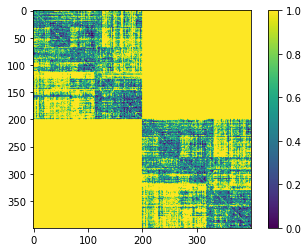

In [135]:
plt.imshow(chisquare_pval_matrix)
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

In [211]:
np.count_nonzero(chisquare_qval_matrix < 0.05)

2004

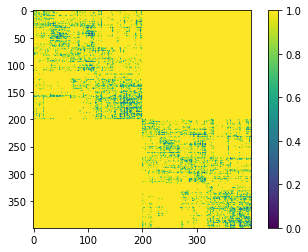

In [131]:
plt.imshow(chisquare_qval_matrix)
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

significant differences shown only

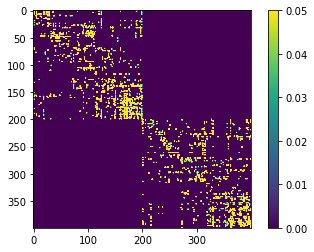

In [175]:
plt.imshow(chisquare_qval_matrix < 0.05)
plt.colorbar()
plt.clim(0, 0.05)
plt.show()

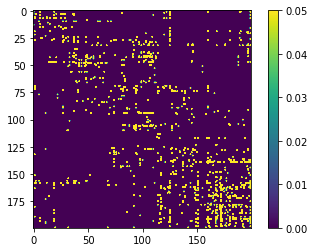

In [187]:
plt.imshow(chisquare_qval_matrix[:200, :200] < 0.05)
plt.colorbar()
plt.clim(0, 0.05)
plt.show()

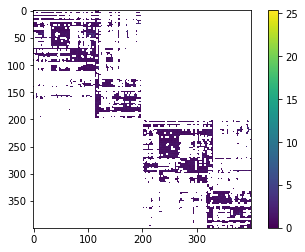

In [168]:
plt.imshow(OR_matrix)
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

In [212]:
np.nanmax(OR_matrix)

25.36117381489842

In [214]:
np.nanmin(OR_matrix)

0.0

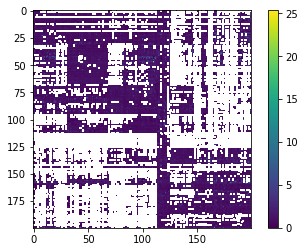

In [216]:
plt.imshow(OR_matrix[:200, :200])
plt.colorbar()
#plt.clim(0, 0.1)
plt.show()

### Display results in interpretable way

#### Parcels showing the greatest sex differences in connectivity profiles -> Number of connections (per parcel, i.e. out of /400 connections) that show a significant sex difference)

In [179]:
num_sig_q_vals_per_area = []

for i in range(400):
    num_sig_q_vals_per_area.append(np.count_nonzero(chisquare_qval_matrix[i] < 0.05))
    
num_sig_q_vals_per_area = np.array([float(e) for e in num_sig_q_vals_per_area])    

In [180]:
num_sig_q_vals_per_area

array([ 0.,  9.,  3.,  8.,  6.,  0.,  2., 14.,  0.,  1.,  9.,  1.,  2.,
        1.,  1.,  5.,  4.,  1.,  0.,  7.,  2.,  5.,  3.,  3.,  8.,  4.,
        4., 12.,  7., 10.,  1.,  7., 21.,  0.,  0.,  3.,  1.,  2.,  5.,
        9.,  2.,  3., 18., 20.,  5.,  7.,  3., 22., 13.,  1.,  9.,  5.,
        1.,  1.,  0.,  0.,  8.,  1.,  0.,  1.,  1.,  1.,  5.,  3.,  1.,
        6.,  7.,  0.,  0., 10.,  8.,  6.,  4.,  6., 14.,  1.,  4.,  2.,
        2.,  1.,  3.,  4.,  3.,  2.,  4.,  0.,  4.,  1.,  4.,  8.,  4.,
        2.,  3.,  4., 20.,  4.,  0.,  0.,  3.,  0.,  3.,  2.,  2.,  1.,
        4., 11., 15.,  0.,  4.,  2.,  7.,  0.,  0.,  2.,  0.,  0.,  1.,
        9.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  1.,  4., 12.,  7.,  2.,
        6.,  7.,  6.,  2.,  3.,  2.,  6., 14.,  6., 33.,  2.,  2.,  2.,
       11.,  4.,  1.,  3.,  3.,  7.,  4.,  4.,  5.,  2.,  5.,  4.,  1.,
       15.,  4., 24.,  1., 17.,  4., 17., 15.,  7.,  8.,  4.,  6.,  2.,
       14., 14.,  5., 10.,  2.,  4.,  7.,  2.,  2., 19.,  9., 11

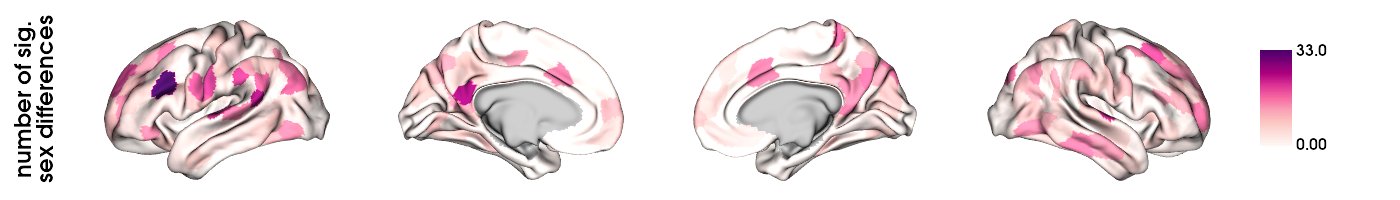

In [183]:
# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0


num_sig_q_vals_per_area_mapped_to_labels = map_to_labels(num_sig_q_vals_per_area, labeling, mask=mask, fill=np.nan)  

num_sig_q_vals_per_area_plotted_hemispheres = plot_hemispheres(
    surf_lh, 
    surf_rh, 
    array_name = num_sig_q_vals_per_area_mapped_to_labels, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = "RdPu",  
    color_bar = True, 
    #color_range='sym',
    nan_color = (0.7, 0.7, 0.7, 1),
    label_text = ["number of sig.\nsex differences"],
    zoom = 1.45, 
    screenshot = False,
    #filename = resdir_fig+'HCP_geo'+'_plotted_hemispheres_mean_distances.png'
)

num_sig_q_vals_per_area_plotted_hemispheres

In [294]:
np.where(num_sig_q_vals_per_area == 33)

(array([139]),)

In [288]:
from nilearn.datasets import fetch_atlas_schaefer_2018

schaefer400_labels = fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)['labels']

In [295]:
schaefer400_labels[139]

b'7Networks_LH_Cont_PFCl_6'

#### Chord plots showing sex differences by network (including source/target) with OR weighting

# STILL NEED TO DETERMINE IF OR WEIGHTING IS INTERPRETABLE

In [284]:
dict_connections_chord_raw = {'source': [], 'target': [], 'weight': []}
dict_connections_chord_by_network = {'source': [], 'target': [], 'weight': []}

for i in range(400):
    
    for j in range(400):
        
        # for connection nodes showing significant sex differences
        if chisquare_qval_matrix[i][j] <= 0.05:
            
            # append to raw dictionary
            dict_connections_chord_raw['source'].append(i)
            dict_connections_chord_raw['target'].append(j)
            dict_connections_chord_raw['weight'].append(OR_matrix[i][j])
            
            # append to dictionary by network
            dict_connections_chord_by_network['source'].append(yeo7_networks_array_labels[i])
            dict_connections_chord_by_network['target'].append(yeo7_networks_array_labels[j])
            dict_connections_chord_by_network['weight'].append(OR_matrix[i][j])
            
            

df_connections_chord_raw = pd.DataFrame(dict_connections_chord_raw)
df_connections_chord_by_network = pd.DataFrame(dict_connections_chord_by_network)

In [285]:
df_connections_chord_by_network

,source,target,weight
0,visual,visual,0.468132
1,visual,visual,0.564328
2,visual,visual,0.480571
3,visual,limbic,0.552907
4,visual,limbic,0.433356
...,...,...,...
1999,DMN,DMN,0.517798
2000,DMN,DMN,0.529304
2001,DMN,DMN,0.636295
2002,DMN,DMN,0.568863


In [292]:
# https://d3blocks.github.io/d3blocks/pages/html/Chord.html

d3.chord(df_connections_chord_by_network)

#d3.set_node_properties(df, opacity=0.2, cmap=palette_labeled_networks)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Convert to Dictionary.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


# Examples chord plots

In [252]:
# Load d3blocks
from d3blocks import D3Blocks
#
# Initialize
d3 = D3Blocks()
#
# Load example data
df = d3.import_example('energy')
#
# Plot
d3.chord(df)
#


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Downloading [energy] dataset from github source..
[d3blocks] >INFO> Extracting files..
[d3blocks] >INFO> Import dataset: [energy]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> Create directory: [/tmp/d3blocks]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


In [253]:
df

,source,target,weight
0,Agricultural 'waste',Bio-conversion,124.729
1,Bio-conversion,Liquid,0.597
2,Bio-conversion,Losses,26.862
3,Bio-conversion,Solid,280.322
4,Bio-conversion,Gas,81.144
...,...,...,...
63,Thermal generation,District heating,79.329
64,Tidal,Electricity grid,9.452
65,UK land based bioenergy,Bio-conversion,182.010
66,Wave,Electricity grid,19.013


In [262]:
# Load d3blocks
from d3blocks import D3Blocks
#
# Initialize
d3 = D3Blocks(chart='Chord', frame=False)
#
# Import example
df = d3.import_example('energy')
#
# Node properties
d3.set_node_properties(df, opacity=0.2, cmap='tab20')
d3.set_edge_properties(df, color='source', opacity='source')
#
# Show the chart
d3.show()
#
# Make some edits to highlight the Nuclear node
# d3.node_properties
d3.node_properties.get('Nuclear')['color']='#ff0000'
d3.node_properties.get('Nuclear')['opacity']=1
# Show the chart
#
d3.show()
# Make edits to highlight the Nuclear Edge
d3.edge_properties.get(('Nuclear', 'Thermal generation'))['color']='#ff0000'
d3.edge_properties.get(('Nuclear', 'Thermal generation'))['opacity']=0.8
d3.edge_properties.get(('Nuclear', 'Thermal generation'))['weight']=1000
#
# Show the chart
d3.show()

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Extracting files..
[d3blocks] >INFO> Import dataset: [energy]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Convert to Dictionary.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Open browser: /tmp/d3blocks/chord.html


# In case I need to play around with computation of contingency table or to understand OR

then can delete

In [157]:
i = 0
j = 4


### creating contingency table with counts of occurances for Chi-square test of indepndence of variables to test if there are statistically significant sex differences in top 10% of fc connections
# C: connection (area) in top 10%; NC: connection (area) not in top 10%; m: male; f: female
# row: male (top), female (bottom)
# columns: C (left), NC right

contingency_table = []
Cm = 0
NCm = 0
Cf = 0
NCf = 0


## male row
Cm = sum(binary_top_fc_M.T[i][j])
NCm = len(binary_top_fc_M) - Cm  # number of male subjects minus sum of counts in the top 10%

# append male row to table
contingency_table.append([Cm, NCm])


## female row
Cf = sum(binary_top_fc_F.T[i][j])
NCf = len(binary_top_fc_F) - Cf  # number of male subjects minus sum of counts in the top 10%

# append female row to table
contingency_table.append([Cf, NCf])

contingency_table = np.array(contingency_table)


# compute Odds Ratio (regardless of pvalue of Chi-square test)
OR = (Cm/NCm)/(Cf/NCf)

# in case the OR == infinity (because dividing by zero), recompute the OR: can replace the 0 at denominator by 0.5 for more interpretability (https://www.researchgate.net/post/How_to_calculate_OR_odd_ratio_if_one_of_groups_is_0_in_a_case-control_study)
if OR == float('inf'):
    OR = (Cm/NCm)/0.5



# only run Chi-square test if there aren't just zeros in both columns (ie either male or female has area as one of top connections (totC > 0) or not all males and all females have area chosen as top connection (totNC > 0) - otherwise throws an error
if (Cm + Cf > 0) and (NCm + NCf > 0):
    ### Chi-square test of independence of variables in a contingency table, [1] indexes the p val
    p_val = stats.chi2_contingency(contingency_table)[1]




/tmp/ipykernel_4312/790154624.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  OR = (Cm/NCm)/(Cf/NCf)


In [158]:
contingency_table

array([[  3, 461],
       [  0, 536]])

In [207]:
Cf

0

In [208]:
NCf

536

In [206]:
Cf/NCf

0.0

In [156]:
(Cm/NCm)/0.5

0.013015184381778741

In [159]:
OR

0.013015184381778741

In [160]:
p_val

0.19890908789151832